<a href="https://colab.research.google.com/github/der41/XAI_Duke/blob/main/Notebooks/Explainable_DL_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Deep Learning
## By Diego Rodriguez

This notebook implement GradCAM and GradCAM variants;to a pre-trained ResNet-50 using a generated image by Sora about traffic in NYC. Also the explainable techniques are used with the data from the [Car Object Detection](https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data) dataset from Kaggle.

In this notebook, I generated visuals cue from the ResNet-50 model using explainable techniques to indentify if the deep learning model is checking the correct spot of the image to detect a particular object. This is done by:

1. Checking GradCAM on the most probably object detected.
2. Checking GradCAM on a blurred patch version image from (1) to detech new objects
3. Checking GradCAM and variants of GradCAM on specifc items present on image (1).
4. Checking GradCAM on other images.

Finally, you can find a reflection to discuss the visual cues that the model attends to and why model explainability is important when using a computer vision deep learning model.

Note: No LLM was used in the elaboration of this notebook. Most of the functions used here are modifications from the pytorch-grad-cam [repo](https://github.com/jacobgil/pytorch-grad-cam).

## Installing dependencies and Imports

In [1]:
from typing_extensions import dataclass_transform
import os

# Remove Colab default sample_data
!rm -r ./sample_data ./XAI_Duke

# Clone GitHub files to colab workspace
repo_name = "XAI_Duke"
git_path = 'https://github.com/der41/XAI_Duke.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = 'Notebooks'
picture_dir = 'data/taxi.png'
notebook_path = os.path.join(repo_name,notebook_dir)
data_path = os.path.join(repo_name,picture_dir)

rm: cannot remove './XAI_Duke': No such file or directory
Cloning into 'XAI_Duke'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 84 (delta 31), reused 26 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 4.87 MiB | 18.54 MiB/s, done.
Resolving deltas: 100% (31/31), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 6.2 MB/s eta

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import torch
import torch.nn.functional as F
from torchvision import models

import numpy as np
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget, ClassifierOutputSoftmaxTarget, ClassifierOutputTarget
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange

In [3]:
import json
import requests

# Download the ImageNet class index mapping
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(LABELS_URL).text.splitlines()

#This code will print the categorie within the imagenet classes for explainability purposses
#for i in range(len(imagenet_classes)):
  #print(f"{i} is {imagenet_classes[i]}")



#Data and model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 85.1MB/s]


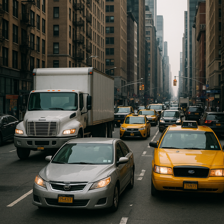

In [4]:
# -----------------------------
# 1) Load image from the repo
# -----------------------------
# Open and convert to RGB (flattens alpha if present)
pil_img = Image.open(data_path)
if pil_img.mode == "RGBA":
    # flatten on white background; change to (0,0,0) for black if preferred
    bg = Image.new("RGB", pil_img.size, (255, 255, 255))
    bg.paste(pil_img, mask=pil_img.split()[-1])
    pil_img = bg
else:
    pil_img = pil_img.convert("RGB")

# Keep an RGB [0..1] version for overlays (224x224 to match model's center crop later)
rgb_img = np.float32(pil_img.resize((224, 224))) / 255.0

# pytorch-grad-cam helper: preprocess to normalized CHW tensor
input_tensor = preprocess_image(
    rgb_img,  # expects HWC float32 [0..1] RGB
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

device = "cuda" if torch.cuda.is_available() else "cpu"
input_tensor = input_tensor.to(device)


# -----------------------------
# 2) Load the model from the repo
# -----------------------------

#Resnet-50 Pretrained
model = models.resnet50(pretrained=True)
model.eval()

targets = [ClassifierOutputTarget(468)] #468 is for cab
target_layers = [model.layer4]

#A look to the orignal image
orig = np.uint8(255 * rgb_img)  # back to 0–255 RGB
Image.fromarray(orig)

I'll be analyzing this picture from NYC. This picture was syntetically generated using Sora, so Res-net50 Imagenet has never seen this arrangement before on training.

### GradCAM - Cab detection

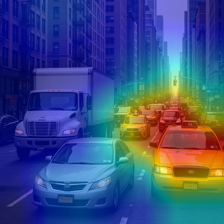

In [5]:
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)
Image.fromarray(cam_image)


Here, we can see how the ResNet50 model behaves in predicting Cab within the image. The model highlights the pixeles that were more important for the prediction in red and orange, showing a high level of confidence in the prediction that a cab is present based on the information at the right of the picture.

Let's check which are the probabilities that the model assign to the most likely items in the picture:

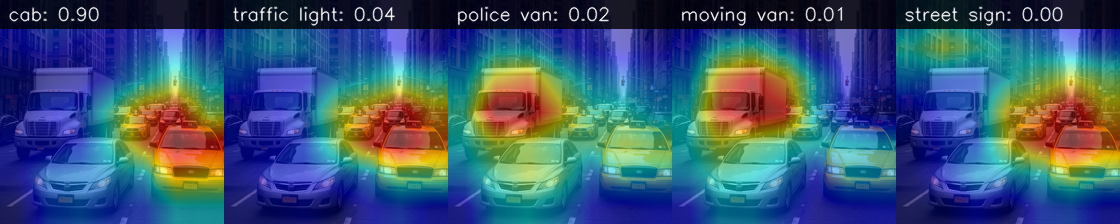

In [6]:
# 2) Get top-5 predictions
with torch.no_grad():
    logits = model(input_tensor)           # [1, 1000]
    probs = torch.softmax(logits, dim=1)   # [1, 1000]
    top_probs, top_idxs = torch.topk(probs, k=5, dim=1)

top_idxs = top_idxs[0].cpu().numpy().tolist()
top_probs = top_probs[0].cpu().numpy().tolist()

# 3) Try to load class names (newer torchvision provides them via weights metadata)
try:
    classes = models.ResNet50_Weights.DEFAULT.meta["categories"]
except Exception:
    classes = None  # Fallback: we'll just show indices if names aren't available

# If your variable is named `img` (float32 in [0,1]), use that as rgb_img:
try:
    rgb_img
except NameError:
    rgb_img = img  # ensure rgb_img exists and is float32 in [0,1], shape (H,W,3)

# 4) Build Grad-CAMs for each of the top-5
overlays = []
with GradCAM(model=model, target_layers=target_layers) as cam:
    for cls_idx, p in zip(top_idxs, top_probs):
        targets = [ClassifierOutputTarget(int(cls_idx))]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)  # uint8

        # Add a label strip at the top with class name and prob
        label = classes[cls_idx] if classes else f"class {cls_idx}"
        text = f"{label}: {p:.2f}"
        canvas = cam_image.copy()
        h, w, _ = canvas.shape
        # semi-opaque bar
        cv2.rectangle(canvas, (0, 0), (w, 28), (0, 0, 0), thickness=-1)
        canvas = cv2.addWeighted(canvas, 0.8, cam_image, 0.2, 0)
        # text
        cv2.putText(canvas, text, (8, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)

        overlays.append(canvas)

# 5) Stack into a grid (1x5 or 2x3 depending on taste). Here: 1 row of 5
grid = cv2.hconcat(overlays)

Image.fromarray(grid)

The model is detecting Cab as the most likely item with a 90% confidence. Far below it has a confidence of 4% on detecting a traffic light, which is slightly higher heatmap gradient than the one used for detecting the cab, but not high enough to the traffic signal detection.

The other top detected categories are way lower and not necessarily correct. When developing inference, one thing that we can do is to put a patch on the most likely predicted object, and evaluate how the predictions align with the active neurons in GradCAM.

## Modified image - GradCAM

In [7]:

img = cv2.imread(data_path)   # BGR format
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define the taxi bounding box (x, y, w, h) -- you can tune these
x, y, w, h = 550, 500, 480, 400

# Extract region of interest (ROI)
roi = img[y:y+h, x:x+w]

# Apply Gaussian blur to the ROI
roi_blurred = cv2.GaussianBlur(roi, (101, 101), 60)

# Put back blurred ROI into the image
img_blurred = img.copy()
img_blurred[y:y+h, x:x+w] = roi_blurred

# Save or show
cv2.imwrite("taxi_scene_blurred.jpg", img_blurred)

True

In [8]:
### Gel
def preprocess_bgr(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_f = (img_resized.astype(np.float32) / 255.0)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    x = (img_f - mean) / std
    x = np.transpose(x, (2,0,1))[None, ...]
    return img_rgb, torch.from_numpy(x)

def top5(model, x):
    with torch.no_grad():
        probs = torch.softmax(model(x), dim=1)[0]
    p, idx = torch.topk(probs, 5)
    return p.cpu().numpy(), idx.cpu().numpy()

def gradcam_grid(model, x, rgb_224, idxs, probs, classes, target_layers):
    tiles = []
    with GradCAM(model=model, target_layers=target_layers) as cam:
        for cls, p in zip(idxs, probs):
            targets = [ClassifierOutputTarget(int(cls))]
            gcam = cam(input_tensor=x, targets=targets)[0]  # (224,224)
            overlay = show_cam_on_image(rgb_224.astype(np.float32)/255.0, gcam, use_rgb=True)
            label = classes[cls] if classes else f"class {cls}"
            text = f"{label}: {p:.2f}"
            # draw header
            canvas = overlay.copy()
            cv2.rectangle(canvas, (0,0), (canvas.shape[1], 28), (0,0,0), -1)
            cv2.putText(canvas, text, (8,20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
            tiles.append(canvas)
    return cv2.hconcat(tiles)

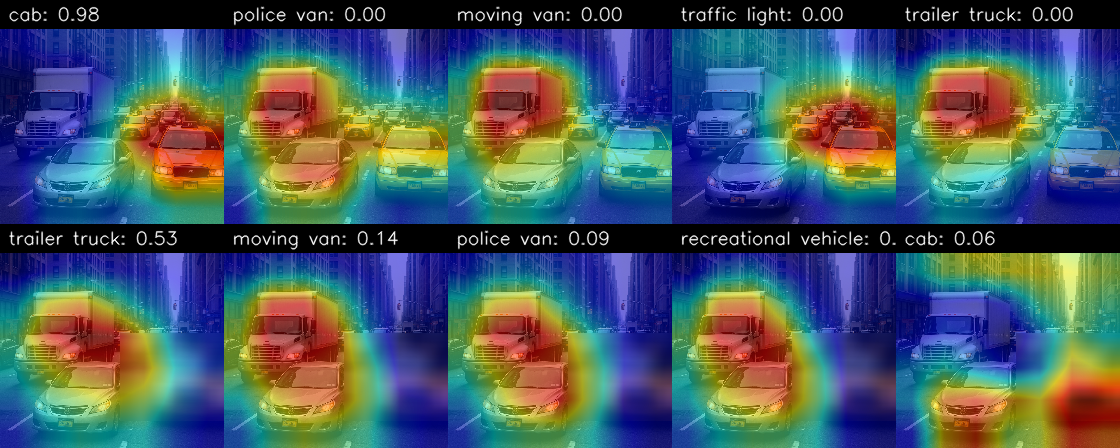

In [9]:
# ---- class names ----
try:
    classes = models.ResNet50_Weights.DEFAULT.meta["categories"]
except Exception:
    # fallback file if needed:
    import requests
    classes = requests.get("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt").text.splitlines()

# ---- model / layer ----
model.eval()
target_layers = [model.layer4[-1]]

# ---------- ORIGINAL ----------
orig_bgr = cv2.imread(data_path)
rgb_224, x = preprocess_bgr(orig_bgr)
p1, i1 = top5(model, x)
panel_orig = gradcam_grid(model, x, cv2.resize(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB),(224,224)), i1, p1, classes, target_layers)

# ---------- BLURRED ----------
blur_bgr = cv2.imread("taxi_scene_blurred.jpg")
rgb_224_b, xb = preprocess_bgr(blur_bgr)
p2, i2 = top5(model, xb)
panel_blur = gradcam_grid(model, xb, cv2.resize(cv2.cvtColor(blur_bgr, cv2.COLOR_BGR2RGB),(224,224)), i2, p2, classes, target_layers)

# Combine panels (original on top, blurred below)
combo = cv2.vconcat([panel_orig, panel_blur])
Image.fromarray(combo)

On the modified picture, the model is predicting with high confidence (53%) that there is a tralier truck on the center left area of the picture. Almost all of the predictions on the second row, highlight attention on the same spot, again with a far lower probability than the objects on the left column.

It is interesting to highlight that on the modified picture the model still able to see a cab on the right side of the image with a low confidence (6%). GradCAM also is not able to mantain a high attention on a specific segment of the image.

### Comparison across different CAMS

100%|██████████| 64/64 [08:38<00:00,  8.11s/it]


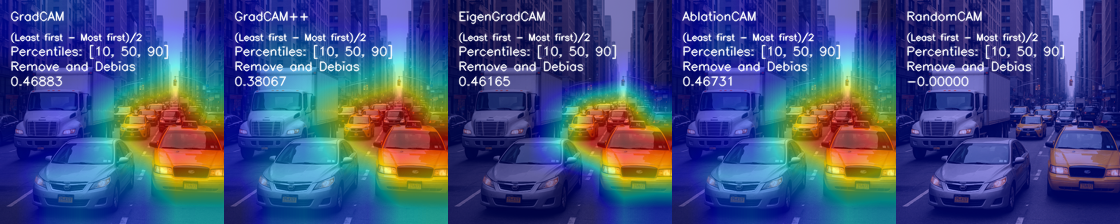

In [10]:

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(rgb_img, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

#Model prediction of a Cab
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=468)

In this particular case, we can oberserved how the cab prediction behaves under different gradCAMs variations. Just a brief explanation of each:

* GradCAM: takes the gradient of the target class score w.r.t. feature maps, averages gradients spatially, and uses these as weights to linearly combine feature maps. (This is the one I have used in the previous exercises)

* GradCAM++: Refines the weighting by considerings second order partial derivatives, not just the first-order average.

* EigenGradCAM: Instead of gradients, it uses principal component analysis (PCA) on the activations to find the dominant eigenvector direction that explains the most variance in importance.

* AbliationCAM: Doesn’t rely on gradients. Instead, it ablates (turns off) feature maps one by one and measures the drop in class score. The bigger the drop, the more important that feature map.

* Random-CAM (Baseline): Assigns random weights to feature maps.Baseline to show what a useless CAM looks like aon the particular picture.

In this particular case, EigenGradCAM seems to focus more pricesily on the cab than the others, while mantaining similar scores than GradCAM and AbliationCAM.


100%|██████████| 64/64 [08:18<00:00,  7.79s/it]


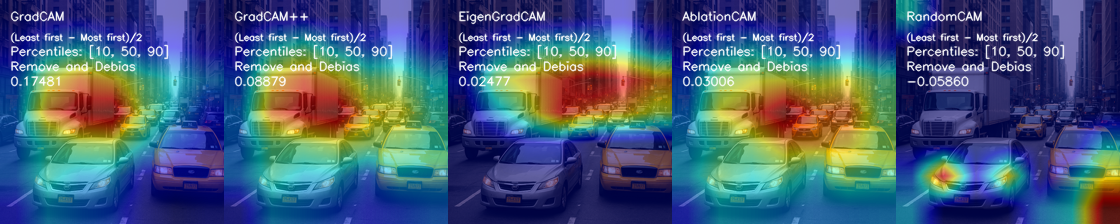

In [32]:
#Model prediction of a Truck
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=867)

When it comes down to predict Trailer Truck on the original image, there is a better performance onf GradCAM compared to other metrics. This lower overall focus is in partly explained that the model has a hard time focusing in other objects than Cab (explored in the initial exercise).

The other CAM variants shows even a lower focus in the image and the score in trying to identify the Trailer Truck. Highligthing some limitation on the model performance for second-order objects within a image.

100%|██████████| 64/64 [08:00<00:00,  7.51s/it]


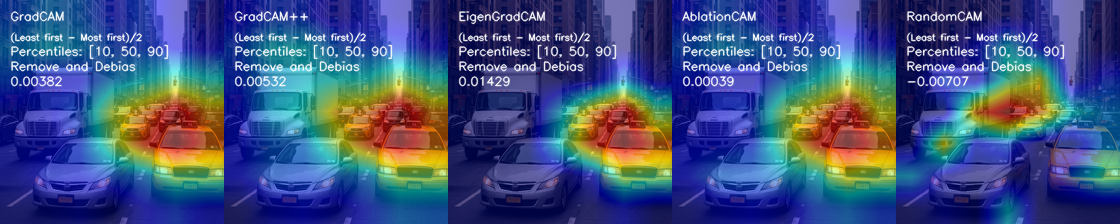

In [33]:
#Model prediction of a traffic light
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=920)

The Traffic light is a small object in the picture. There are bigger and more characteristics distraction through out the picture. The neurons highlights about traffic lights are very low and they fail to target the specific area where the traffic light is located, it doesn't seem to be different than a randomCAM evaluation.

Further training or complementary techniques (e.g blurring) should be used to increase the capability of the model on detecting traffic lights or other small objects when it is not the main part of the image.

To test this further lets use 3 different picture from the Car object detection dataset. Here we will see objects from the perspective of a driving car, so objects will be naturally small and in some cases affected by movemnet.

## Other figure performance

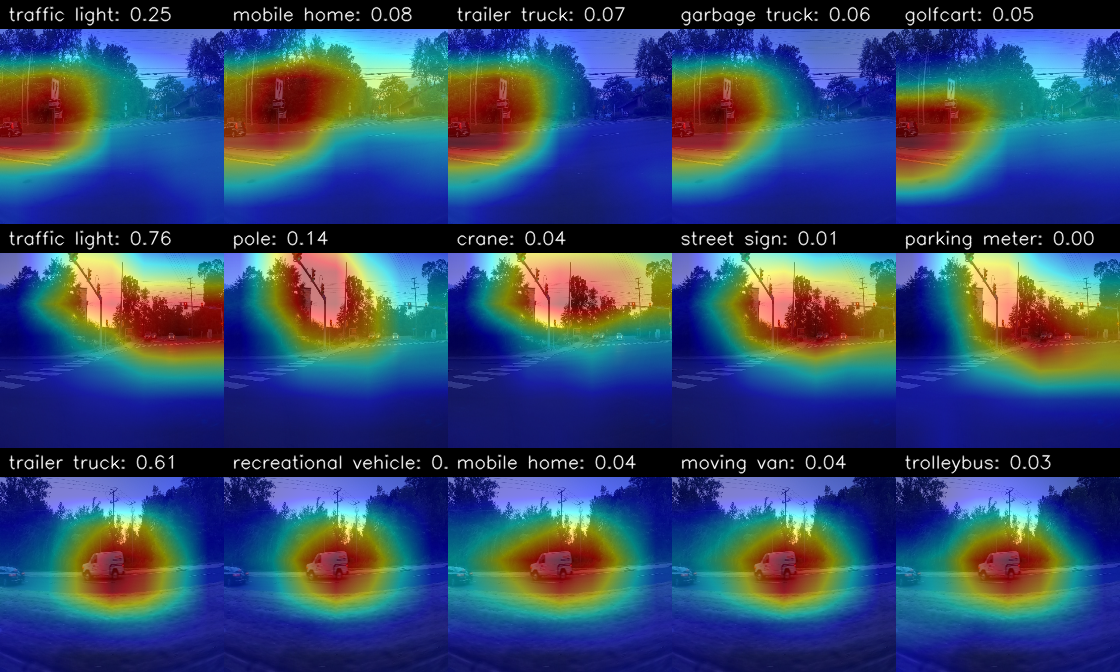

In [12]:
# ---------- IMAGE 1 ----------
traffic_light = cv2.imread("/content/XAI_Duke/data/traffic_sign.jpg")
rgb_224, x = preprocess_bgr(traffic_light)
p1, i1 = top5(model, x)
panel_1 = gradcam_grid(model, x, cv2.resize(cv2.cvtColor(traffic_light, cv2.COLOR_BGR2RGB),(224,224)), i1, p1, classes, target_layers)

# ---------- IMAGE 2 ----------
intersection = cv2.imread("/content/XAI_Duke/data/intersection.jpg")
rgb_224_b, xb = preprocess_bgr(intersection )
p2, i2 = top5(model, xb)
panel_2 = gradcam_grid(model, xb, cv2.resize(cv2.cvtColor(intersection, cv2.COLOR_BGR2RGB),(224,224)), i2, p2, classes, target_layers)

# ---------- IMAGE 3 ----------
van = cv2.imread("/content/XAI_Duke/data/van.jpg")
rgb_224_b, xb = preprocess_bgr(van)
p2, i2 = top5(model, xb)
panel_3 = gradcam_grid(model, xb, cv2.resize(cv2.cvtColor(van, cv2.COLOR_BGR2RGB),(224,224)), i2, p2, classes, target_layers)


# Combine panels (original on top, blurred below)
combo = cv2.vconcat([panel_1, panel_2, panel_3])
Image.fromarray(combo)

The first row of image shows an intersection. In all major cases the model is fixated on the left side of the image. There is a small black car with red lights which the model considers to be a traffic light with low probability (25%).

On the second row of images, the model is successful on recognizing the traffic lights, in this case they use a bigger portion of pixel than in the NYC case. It is also one of the main objects of the figure, the area of the gradCAM is a bit larger than the expected for the area of the traffic light but is signaling the correct places of the image (first image on the far left column).

Finally, the model is able to detect the vehichle at the center, using a more precise set of pixels. However, is not able to fully indentify that this is a moving van.


## Final Comments

GradCAM provides an intuitive and powerful way to see into the “black box” of deep convolutional models such as ResNet-50 by highlighting the image regions that drive specific class predictions. Instead of only reporting confidence scores, it generates heatmaps that reveal why the network arrives at a decision, making the underlying reasoning process far more transparent. In the case of the taxi image, Grad-CAM clearly localized the model’s attention on the characteristic yellow cab features, reassuring us that the prediction stems from meaningful object cues rather than spurious background patterns.

Also, this techniques helped me to check where the model was performing worse by checking this technique through modify images and different images. This helps bridge the gap between raw neural computations and human interpretability, making complex architectures easier to trust and debug.

Overall, Grad-CAM supports a range of practical benefits for model development and evaluation in computer vision. By visually validating what the network focuses on, practitioners can detect potential biases, confirm the robustness of predictions, and identify failure modes where the model relies on irrelevant context. Coupled with quantitative faithfulness measures, explainable techniques not only strengthens confidence in model outputs but also guides improvements in dataset quality and model design.